In [1]:
import pygmo as pg
import numpy as np
from optim.problem import SignalProcessingParams
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import latin
from SALib.analyze import rbd_fast
from SALib import ProblemSpec
import pandas as pd

## Sensitivity analysis

In [2]:
# Create problem instance (load data and prepare for optimization/sensitivity)
prob = pg.problem(SignalProcessingParams(measure_position=4))
print(prob)
prob_extract = prob.extract(SignalProcessingParams)
# print(prob_extract.file_names)
# fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
# ax[0].plot(prob_extract.grip_dat[10].ravel())
# ax[1].plot(prob_extract.emg_dat[10].ravel())

Problem name: Optimize EMG signal processing parameters to cross-corelate with grip force
	C++ class name: pybind11::object

	Global dimension:			250
	Integer dimension:			1
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [5, 5, 5, 5, 5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Sampling rate: 992.969696969697 Hz
	FFT window size: 496 samples
	FFT resolution: 2.0019550342130987 Hz



### Input variables and Problem definition

In [4]:
# Decision vector parameter names using FFT frequencies + decay factor and smoothing window size
param_names = list(np.round(prob_extract.emg_fft_freq[1:], decimals=2))
param_names = ['f' + str(i) for i in param_names] + ['decay', 'window']
param_names = [i.replace('.', '_') for i in param_names]

# Wrapper for evaluation function
def corr_eval(X: np.ndarray, func = prob) -> np.ndarray:
    # import numpy as np
    
    # Iterate over the sample rows (decision vectors) and evaluate the fitness function
    results = np.fromiter(
        iter=(func.fitness(i) for i in X),
        dtype=np.float64, 
        count=X.shape[0]
        )
    return 1. - results.ravel()

# Define the sensitivity problem model
sensitivity_problem = ProblemSpec({
    # 'num_vars': len(param_names),
    # 'groups': ['freqs'] * (len(param_names)-2) + ['decay', 'window'],
    'names': param_names,
    # Get bounds from the problem instance, just reframe in [low, high] format
    'bounds': [[low, up] for low, up in zip(*prob_extract.get_bounds())],
    'outputs': ['corr'],
})

In [ ]:

# Run the pipeline - sample, evaluate, analyze
(
    sensitivity_problem.sample_latin(N=3072)
    # sensitivity_problem.sample_saltelli(N=1024, calc_second_order=False)
    .evaluate(corr_eval, nprocs=4)
    .analyze_hdmr(nprocs=4, maxorder=2, maxiter=200, m=2, K=20, print_to_console=True)
    # .analyze_rbd_fast(nprocs=4, num_resamples=300, print_to_console=True)
    # .analyze_sobol( calc_second_order=False, num_resamples=100, conf_level=0.95, nprocs=4, print_to_console=True)
)
print()


In [5]:
# Generate samples
param_values = latin.sample(problem=sensitivity_problem, N=10000)
print(f"Parameter samples: {param_values.shape}")

# Evaluate model
corrs = corr_eval(param_values)
print(f"Model evaluations: {corrs.shape}")

Parameter samples: (10000, 250)
Model evaluations: (10000,)


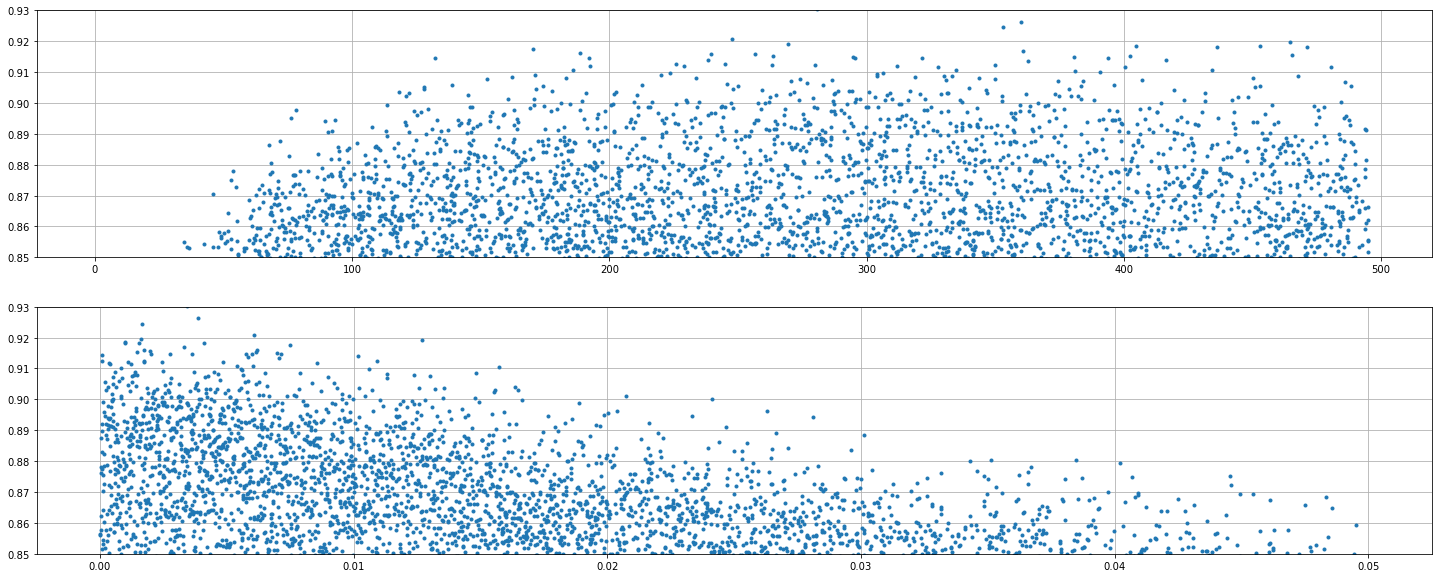

In [10]:
# Convert results to pandas
lh_evaluate = pd.DataFrame(
    np.hstack((param_values, corrs[:, np.newaxis])), 
    columns=[*param_names, 'corrs']
    )

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25, 10))
# Window size vs correlation
ax[0].plot(lh_evaluate.window, lh_evaluate.corrs, '.')
ax[0].set_ylim([0.85, 0.93])
# Decay factor vs correlation
ax[1].plot(lh_evaluate.decay, lh_evaluate.corrs, '.')
ax[1].set_ylim([0.85, 0.93])
for a in ax:
    a.grid()

In [11]:
# Export results to csv
lh_evaluate.to_csv('results/sensitivity_preliminary_lh_pos4.csv', index=False)

In [ ]:

# Compute the sensitivity indices - first order only
sensitity_indices = rbd_fast.analyze(
    problem=sensitivity_problem, X=param_values, Y=corrs, 
    M=10, num_resamples=1000, conf_level=0.95,
    print_to_console=True
    )
# print('Sensitivity analysis complete')

In [19]:
10000 * 42 * 1e-3 / 60

7.0

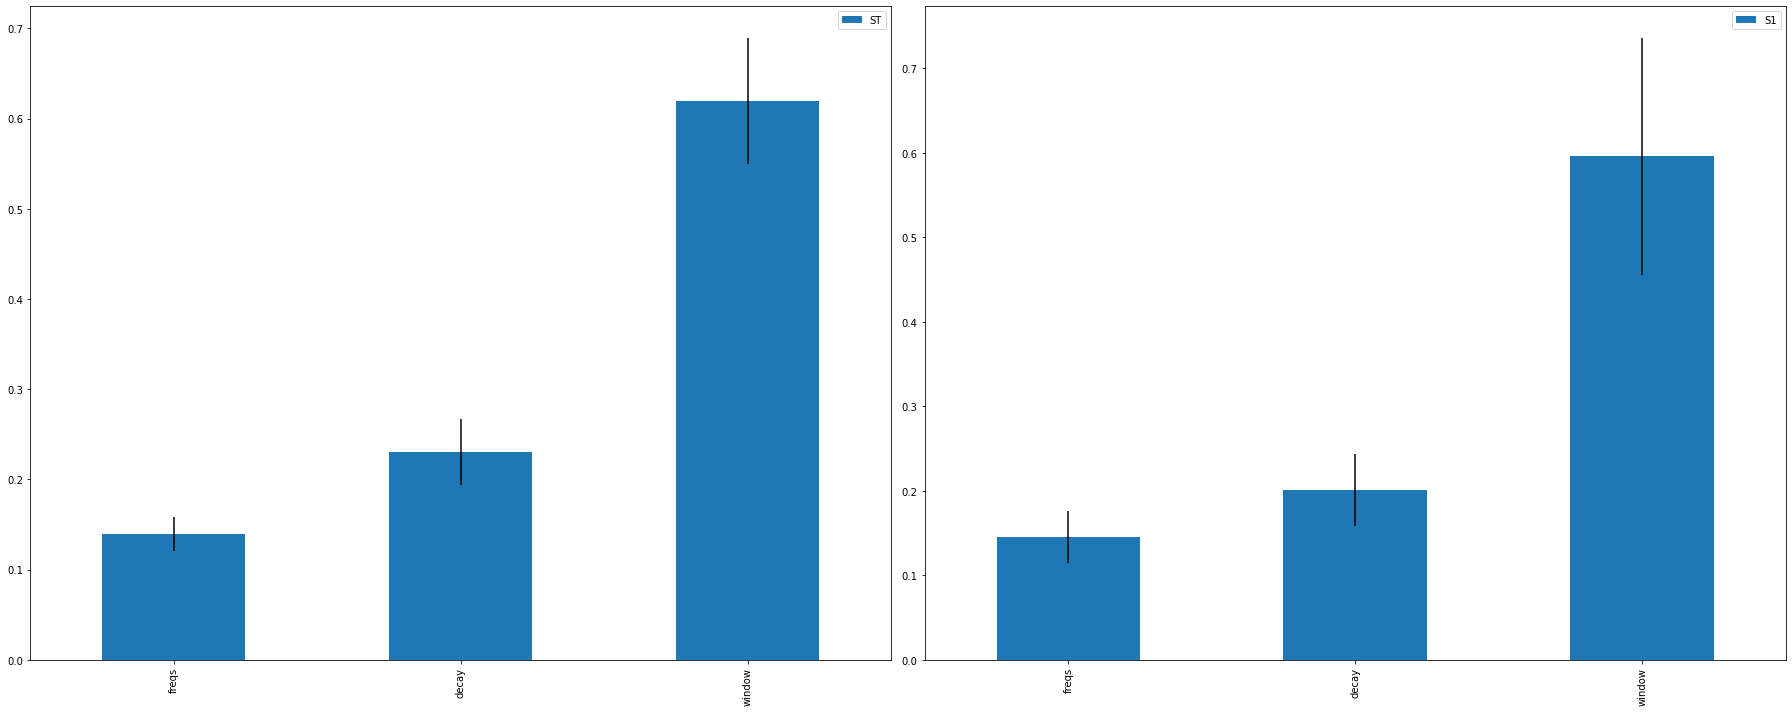

In [38]:
ax = sensitivity_problem.plot()
# ax.set_yscale('log')
# ax.set_ylim([0, 0.003])
fig = plt.gcf()  # get current figure
# plt.xticks(rotation=45)
fig.set_size_inches(25, 10)
plt.locator_params(axis='x', nbins=100)
plt.tight_layout()

In [16]:
sensitivity = sensitivity_problem.to_df()
sensitivity.sort_values('ST', ascending=False, inplace=True)
sensitivity.head(30)
# sensitivity['S'].sum()

,Sa,Sa_conf,Sb,Sb_conf,S,S_conf,ST,ST_conf
f2_0,0.050985,0.042385,6.851341,3.855211,0.075793,0.037508,5.422441,5.605865
window,0.506343,0.050436,8.088531,10.160632,0.505305,0.047480,1.119949,0.216576
f14_01,0.002737,0.003937,-0.875618,2.209884,-0.002230,0.004445,0.843278,1.054507
f4_0,0.006030,0.006418,0.181406,1.259822,0.005355,0.004411,0.628617,0.746189
f98_1,0.001672,0.002312,-0.485750,1.295120,-0.001184,0.003380,0.560765,0.690077
f112_11,0.001680,0.002193,-0.531180,1.505996,-0.001058,0.002697,0.544735,0.565598
decay,0.221250,0.038910,3.696818,4.935102,0.219934,0.044566,0.539175,0.222896
f86_08,0.001736,0.002321,-0.462368,1.437918,-0.000786,0.003134,0.537712,0.717887
f26_03,0.002246,0.003628,-0.534738,1.523630,-0.001075,0.001876,0.525821,0.489854
f154_15,0.000738,0.000636,-0.118553,0.414448,-0.000029,0.001520,0.520824,0.603506


In [3]:
# Add parameter names using FFT frequencies
param_names = list(np.round(prob_extract.emg_fft_freq[1:], decimals=2))
param_names = ['f' + str(i) for i in param_names] + ['decay', 'window']
param_names = [i.replace('.', '_') for i in param_names]
np.savetxt('param_names.txt', X=np.column_stack((
  np.arange(start=1, stop=len(param_names)+1), param_names
  )), fmt='%s')
# param_names

In [5]:
# params_select = np.loadtxt('emg_dsample.txt', delimiter=' ')
# params_select = np.loadtxt('emg_lvct_select_11.txt', delimiter=' ')
params_select = np.loadtxt('emg_lvct_select_5.txt', delimiter=' ')
display(params_select.shape)
# selected_params = ('f2_0', 'f4_0', 'f50_05', 'f120_12', 'f124_12', 'f136_13', 'f176_17',
#                    'f414_4', 'f472_46', 'decay', 'window')
selected_params = ('f2_0', 'f4_0', 'f50_05', 'decay', 'window')
# np.savetxt('param_names_select_5.txt', X=np.column_stack((
#   np.arange(start=1, stop=len(selected_params)+1), selected_params
#   )), fmt='%s')
selected_index = [param_names.index(i) for i in selected_params]
display(selected_index)
# Always remove DC offset
params = np.ones((params_select.shape[0], 250))
params[:, selected_index] = params_select
# params = params_select
params = np.column_stack((np.zeros(params.shape[0]), params))
params.shape

(2000, 5)

[0, 1, 24, 248, 249]

(2000, 251)

In [ ]:
corr1 = [1 - prob.fitness(i) for i in params]
# corr2 = [prob2.fitness(i) for i in params]

In [ ]:
min(corr1)
corr2 = np.loadtxt('corr2.csv')
display(corr2[:10])
np.savetxt('corrs_dsample.txt', X=np.column_stack((corr1, corr2)), delimiter=' ')

In [ ]:
# Slicing only first 100 corrs and params
np.savetxt('emg_dsample_100.txt', X=params[:100, 1:], delimiter=' ')
np.savetxt('corrs_dsample_100.txt', X=np.column_stack((corr1, corr2))[:100, :], delimiter=' ')

In [ ]:
%%timeit -n1 -r1
pop1 = pg.population(prob, size=20)

In [ ]:
3300 / 3600

In [ ]:
print(pop1)

In [ ]:
pop1.get_x()[32][-1]

In [ ]:
pop1.champion_x